**1. Uploading the necessary packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import missingno as msno
import geopandas as gpd
from geopy.geocoders import Nominatim
import time
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import plotly.graph_objects as go
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

**2. Import the dataset**: After importing the dataset from the wikipedia page, I decided to choose another, clearer and more complete dataset found through a link on the same wikipedia page (Air Quality Life Index)
;

In [2]:
#url = "https://en.wikipedia.org/wiki/List_of_countries_by_air_pollution" ## URL della pagina di Wikipedia con la tabella desiderata
#tables = pd.read_html(url) ## Utilizza pandas per leggere tutte le tabelle presenti nella pagina
#pollution = tables[0] ## Seleziona la tabella desiderata (per esempio la prima tabella)
#pollution ## Mostra i primi 5 record del dataset
pollution = pd.read_csv("aqli_global.csv")
pollution

,id,name,population,natstandard,pm1998,pm1999,pm2000,pm2001,pm2002,pm2003,...,nat2012,nat2013,nat2014,nat2015,nat2016,nat2017,nat2018,nat2019,nat2020,nat2021
0,AFG,Afghanistan,37461801.0,35.0,10.88,10.70,11.88,13.89,13.58,13.88,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,XAD,Akrotiri and Dhekelia,24378.0,NaN,11.74,11.67,13.73,12.67,10.96,11.43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ALB,Albania,3082234.0,25.0,16.86,15.43,17.33,16.42,18.07,20.11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,DZA,Algeria,43480294.0,NaN,6.41,5.72,6.12,6.19,6.18,7.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ASM,American Samoa,43160.0,NaN,0.73,0.82,1.11,1.01,1.17,1.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,ESH,Western Sahara,646462.0,NaN,5.15,6.73,5.10,5.12,5.21,4.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248,YEM,Yemen,30314666.0,NaN,11.61,13.60,13.95,11.74,13.43,13.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249,ZMB,Zambia,19089070.0,NaN,16.16,13.84,16.91,24.61,22.21,21.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250,ZWE,Zimbabwe,14804978.0,NaN,17.08,13.76,13.88,21.20,16.99,18.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**2. Data cleaning**

In [3]:
pollution = pollution.filter(items=['name', 'population', 'pm2010', 'pm2011', 'pm2012', 'pm2013', 'pm2014', 'pm2015', 'pm2016', 'pm2017', 'pm2018', 'pm2019', 'pm2020', 'pm2021','who2019','who2020','who2021'])
pollution
#Filtered the DataFrame to keep only the most useful variables, including: country, population, PM2.5 level from 2010 to 2021 and the increase in life expectancy from 2019 to 2021


,name,population,pm2010,pm2011,pm2012,pm2013,pm2014,pm2015,pm2016,pm2017,pm2018,pm2019,pm2020,pm2021,who2019,who2020,who2021
0,Afghanistan,37461801.0,15.26,18.31,16.34,14.97,15.49,16.09,16.20,15.25,14.04,16.56,16.57,16.90,1.13,1.13,1.17
1,Akrotiri and Dhekelia,24378.0,10.38,15.61,17.16,11.96,11.13,11.77,10.76,11.23,9.97,9.74,10.71,11.15,0.46,0.56,0.60
2,Albania,3082234.0,11.80,20.51,17.55,14.53,12.87,16.26,13.65,15.04,14.43,13.65,13.09,13.53,0.85,0.79,0.84
3,Algeria,43480294.0,5.52,7.03,6.85,6.59,5.36,7.02,5.61,6.62,6.05,6.09,5.83,6.15,0.11,0.08,0.11
4,American Samoa,43160.0,1.02,0.95,1.11,1.10,1.22,1.49,1.26,1.29,1.39,1.34,1.07,1.02,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,Western Sahara,646462.0,3.41,3.60,3.10,3.64,4.41,3.34,3.81,3.67,5.53,4.60,3.78,4.84,0.00,0.00,0.00
248,Yemen,30314666.0,16.47,18.09,15.44,15.11,15.83,16.15,15.04,15.49,16.73,16.46,14.15,14.75,1.12,0.90,0.96
249,Zambia,19089070.0,23.58,20.68,21.84,20.61,20.01,21.97,20.27,19.40,19.84,20.47,18.04,18.50,1.52,1.28,1.32
250,Zimbabwe,14804978.0,19.63,15.47,17.25,15.85,15.07,17.37,15.48,15.17,16.64,15.91,12.26,14.36,1.07,0.71,0.92


In [4]:
na_counts = pollution.isna().sum() ## displaying null values
print(na_counts)

name          0
population    7
pm2010        7
pm2011        7
pm2012        7
pm2013        7
pm2014        7
pm2015        7
pm2016        7
pm2017        7
pm2018        7
pm2019        7
pm2020        7
pm2021        7
who2019       7
who2020       7
who2021       7
dtype: int64


In [5]:
pollution = pollution.dropna() ## elimination of observations with null values
na_counts = pollution.isna().sum()
print(na_counts)

name          0
population    0
pm2010        0
pm2011        0
pm2012        0
pm2013        0
pm2014        0
pm2015        0
pm2016        0
pm2017        0
pm2018        0
pm2019        0
pm2020        0
pm2021        0
who2019       0
who2020       0
who2021       0
dtype: int64


**3. EDA**: I decided to analyse and plot the 10 countries with the highest variance value to see their behaviour over the years

In [6]:
pm_columns = [col for col in pollution.columns if col.startswith("pm")] ## Calculate the variance of PM values for each country
pollution["pm_variance"] = pollution[pm_columns].var(axis=1) ## The variance is calculated along the rows, which means that it calculates the variance for each row (each row is treated as a group of values on which to calculate the variance).
## Sort the DataFrame according to the variance of PM values
pollution_by_variance = pollution.sort_values(by="pm_variance", ascending=False)
pollution_by_variance

<ipython-input-6-5a186434cffd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollution["pm_variance"] = pollution[pm_columns].var(axis=1) ## The variance is calculated along the rows, which means that it calculates the variance for each row (each row is treated as a group of values on which to calculate the variance).


,name,population,pm2010,pm2011,pm2012,pm2013,pm2014,pm2015,pm2016,pm2017,pm2018,pm2019,pm2020,pm2021,who2019,who2020,who2021,pm_variance
45,China,1.402508e+09,46.72,52.48,49.02,52.29,50.21,46.85,43.41,40.91,35.83,35.09,31.91,30.20,2.95,2.64,2.47,63.482182
198,Singapore,5.842829e+06,12.61,15.32,17.53,23.12,18.10,26.26,13.87,13.12,13.90,18.60,11.49,13.01,1.33,0.64,0.78,20.538499
17,Bangladesh,1.648048e+08,65.88,69.93,70.67,65.79,68.81,65.15,65.38,63.06,75.78,67.00,75.59,73.96,6.08,6.92,6.76,18.623061
115,Kosovo,1.930871e+06,21.84,34.43,31.13,27.83,24.74,27.33,25.02,25.23,25.45,20.96,21.76,20.79,1.56,1.64,1.55,17.387293
127,Macedonia,2.120037e+06,22.08,34.28,31.17,27.65,26.16,28.42,26.02,25.95,26.52,23.08,21.31,22.89,1.77,1.60,1.75,14.426154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,French Polynesia,2.373150e+05,1.17,1.05,1.22,1.24,1.41,1.41,1.18,1.19,1.34,1.41,1.41,1.40,0.00,0.00,0.00,0.015772
134,Marshall Islands,3.395100e+04,1.16,1.01,0.90,1.04,1.19,1.14,0.97,0.91,1.23,1.04,0.95,0.98,0.00,0.00,0.00,0.012442
51,Cook Islands,6.273000e+03,0.95,0.90,1.01,1.00,1.08,1.18,1.03,1.05,1.12,1.21,1.20,0.96,0.00,0.00,0.00,0.010475
158,Niue,1.864000e+03,0.94,0.93,1.02,1.00,0.95,1.04,0.91,1.07,1.05,1.07,1.00,0.94,0.00,0.00,0.00,0.003315


In [7]:
top_variance_states = pollution_by_variance.head(10) ## Select the top 10 countries with the highest PM variance

In [8]:
top_variance_states

,name,population,pm2010,pm2011,pm2012,pm2013,pm2014,pm2015,pm2016,pm2017,pm2018,pm2019,pm2020,pm2021,who2019,who2020,who2021,pm_variance
45,China,1.402508e+09,46.72,52.48,49.02,52.29,50.21,46.85,43.41,40.91,35.83,35.09,31.91,30.20,2.95,2.64,2.47,63.482182
198,Singapore,5.842829e+06,12.61,15.32,17.53,23.12,18.10,26.26,13.87,13.12,13.90,18.60,11.49,13.01,1.33,0.64,0.78,20.538499
17,Bangladesh,1.648048e+08,65.88,69.93,70.67,65.79,68.81,65.15,65.38,63.06,75.78,67.00,75.59,73.96,6.08,6.92,6.76,18.623061
115,Kosovo,1.930871e+06,21.84,34.43,31.13,27.83,24.74,27.33,25.02,25.23,25.45,20.96,21.76,20.79,1.56,1.64,1.55,17.387293
127,Macedonia,2.120037e+06,22.08,34.28,31.17,27.65,26.16,28.42,26.02,25.95,26.52,23.08,21.31,22.89,1.77,1.60,1.75,14.426154
27,Bosnia and Herzegovina,3.816193e+06,28.34,34.32,29.87,27.02,25.22,30.57,28.72,27.62,26.22,22.40,24.76,23.73,1.71,1.94,1.84,10.767117
175,Poland,3.815684e+07,26.86,24.30,22.21,21.61,21.56,20.08,19.69,20.01,19.54,16.04,15.11,17.95,1.08,0.99,1.27,10.683606
160,North Korea,2.566696e+07,21.55,25.66,25.64,24.55,29.62,28.28,25.36,23.00,20.33,20.42,20.87,20.00,1.51,1.56,1.47,10.542570
130,Malaysia,3.326568e+07,14.04,17.27,17.49,18.52,19.64,23.81,15.16,13.88,14.89,20.02,13.28,13.74,1.47,0.81,0.86,10.496688
34,Bulgaria,6.914894e+06,18.51,28.68,23.17,20.45,19.79,19.12,18.22,19.70,18.86,17.53,18.03,19.01,1.23,1.28,1.37,9.459717


In [9]:
print(top_variance_states.describe())

         population    pm2010     pm2011  pm2012     pm2013     pm2014  \
count  1.000000e+01  10.00000  10.000000  10.000  10.000000  10.000000   
mean   1.685028e+08  27.84300  33.667000  31.790  30.883000  30.385000   
std    4.363466e+08  16.40762  16.507626  16.414  15.490158  16.340139   
min    1.930871e+06  12.61000  15.320000  17.490  18.520000  18.100000   
25%    4.322852e+06  19.27000  24.640000  22.450  21.987500  20.232500   
50%    1.629093e+07  21.96000  31.480000  27.755  25.785000  24.980000   
75%    3.693405e+07  27.97000  34.402500  31.160  27.785000  28.755000   
max    1.402508e+09  65.88000  69.930000  70.670  65.790000  68.810000   

          pm2015    pm2016     pm2017    pm2018     pm2019    pm2020  \
count  10.000000  10.00000  10.000000  10.00000  10.000000  10.00000   
mean   31.587000  28.08500  27.248000  27.73200  26.114000  25.41100   
std    14.048537  15.57839  14.835226  18.07393  15.286106  18.59781   
min    19.120000  13.87000  13.120000  13.900

In [10]:
top_variance_states = top_variance_states.drop(columns=["pm_variance"]) ## Remove column ‘pm_variance’ not needed for further analysis

In [11]:
pollution_melted = top_variance_states.melt(id_vars=["name", "population", "who2019", "who2020", "who2021"],
                    var_name="year",
                    value_name="pm",) ## Melt the dataframe to have years as a single column

pollution_melted["year"] = pollution_melted["year"].str.extract('(\d+)').astype(int) ## Extract the year from the 'year' column

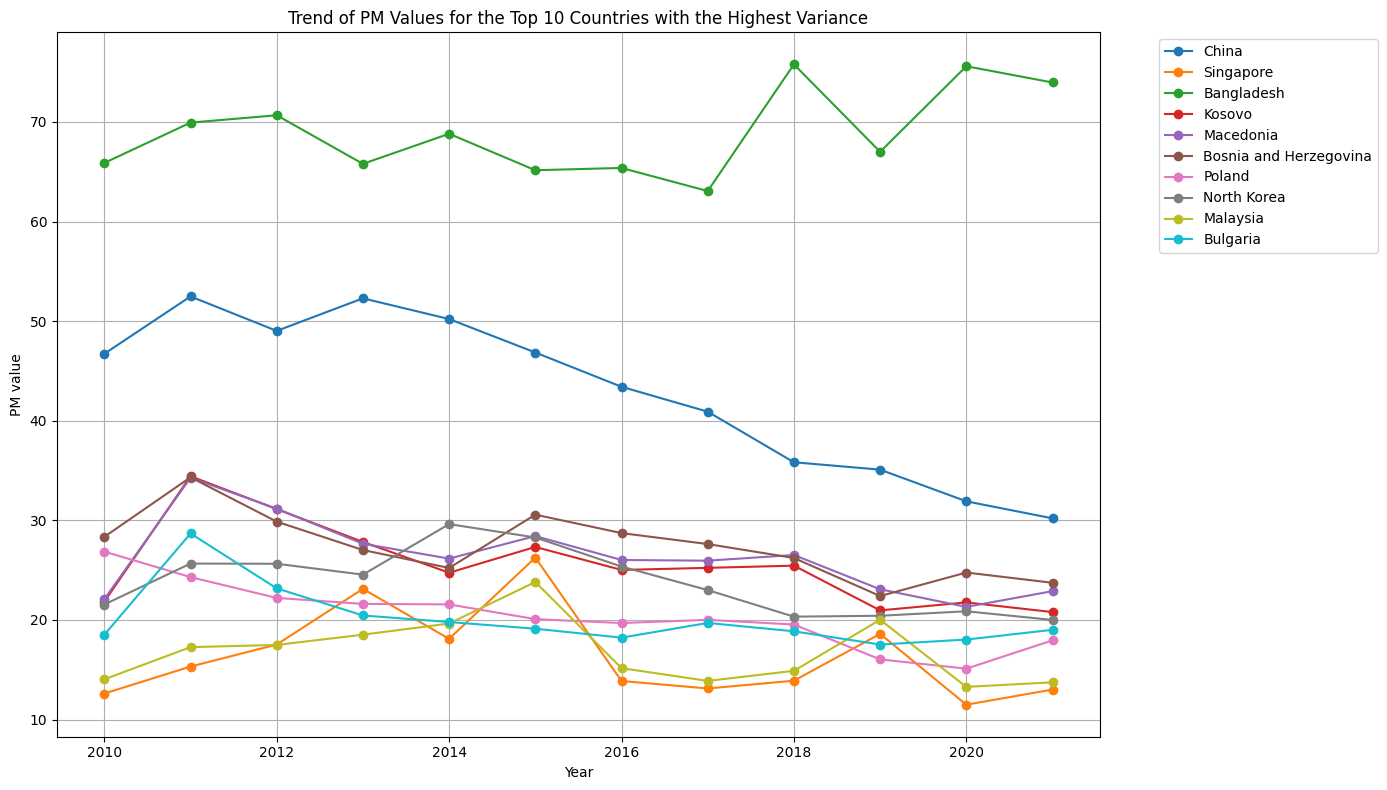

In [12]:
plt.figure(figsize=(14, 8))
for country in pollution_melted["name"].unique():
    country_data = pollution_melted[pollution_melted["name"] == country]
    plt.plot(country_data["year"], country_data["pm"], marker='o', label=country) ## Creating the line graph


plt.title("Trend of PM Values for the Top 10 Countries with the Highest Variance")
plt.xlabel("Year")
plt.ylabel("PM value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Countries like China and North Korea show significant decreasing trends, indicating progress in pollution control measures;
Countries such as Bangladesh and Kosovo show high and relatively stable values, suggesting that air pollution remains a serious problem;
Some countries show fluctuations in PM values, which could be due to various factors such as seasonal, industrial or environmental policy changes.

In [13]:
pollution_meltedG = top_variance_states.melt(id_vars=["name", "population", "pm2010", "pm2011", "pm2012", "pm2013", "pm2014", "pm2015", "pm2016", "pm2017", "pm2018", "pm2019", "pm2020", "pm2021"],
                    var_name="year",
                    value_name="who",)## Melt the dataframe to have years as a single column

pollution_meltedG["year"] = pollution_meltedG["year"].str.extract('(\d+)').astype(int) ## Extract the year from the 'year' column

Using the same procedure as above, I visualised the life expectancy trends over the three years of the countries with the highest PM2.5 variance

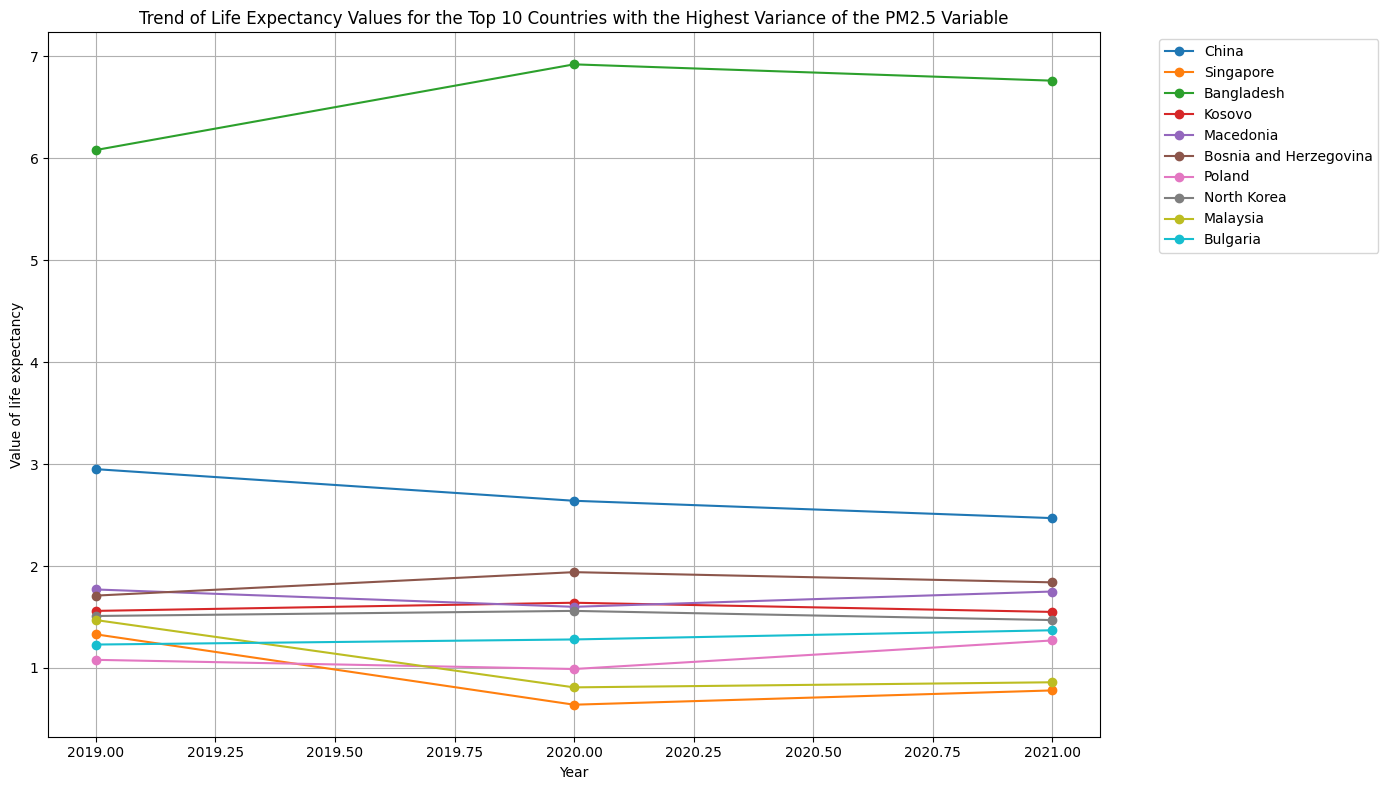

In [14]:
plt.figure(figsize=(14, 8))
for country in pollution_meltedG["name"].unique():
    country_data = pollution_meltedG[pollution_meltedG["name"] == country]
    plt.plot(country_data["year"], country_data["who"], marker='o', label=country) ## Creating the line graph

plt.title("Trend of Life Expectancy Values for the Top 10 Countries with the Highest Variance of the PM2.5 Variable")
plt.xlabel("Year")
plt.ylabel("Value of life expectancy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Although some countries have shown improvements in PM values, pollution continues to have a significant negative impact on public health, reducing life expectancy to varying degrees between countries.

In [15]:
pollution = pollution.drop(columns=['pm_variance']) ## drop variance column
pollution

,name,population,pm2010,pm2011,pm2012,pm2013,pm2014,pm2015,pm2016,pm2017,pm2018,pm2019,pm2020,pm2021,who2019,who2020,who2021
0,Afghanistan,37461801.0,15.26,18.31,16.34,14.97,15.49,16.09,16.20,15.25,14.04,16.56,16.57,16.90,1.13,1.13,1.17
1,Akrotiri and Dhekelia,24378.0,10.38,15.61,17.16,11.96,11.13,11.77,10.76,11.23,9.97,9.74,10.71,11.15,0.46,0.56,0.60
2,Albania,3082234.0,11.80,20.51,17.55,14.53,12.87,16.26,13.65,15.04,14.43,13.65,13.09,13.53,0.85,0.79,0.84
3,Algeria,43480294.0,5.52,7.03,6.85,6.59,5.36,7.02,5.61,6.62,6.05,6.09,5.83,6.15,0.11,0.08,0.11
4,American Samoa,43160.0,1.02,0.95,1.11,1.10,1.22,1.49,1.26,1.29,1.39,1.34,1.07,1.02,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,Western Sahara,646462.0,3.41,3.60,3.10,3.64,4.41,3.34,3.81,3.67,5.53,4.60,3.78,4.84,0.00,0.00,0.00
248,Yemen,30314666.0,16.47,18.09,15.44,15.11,15.83,16.15,15.04,15.49,16.73,16.46,14.15,14.75,1.12,0.90,0.96
249,Zambia,19089070.0,23.58,20.68,21.84,20.61,20.01,21.97,20.27,19.40,19.84,20.47,18.04,18.50,1.52,1.28,1.32
250,Zimbabwe,14804978.0,19.63,15.47,17.25,15.85,15.07,17.37,15.48,15.17,16.64,15.91,12.26,14.36,1.07,0.71,0.92


I searched on kaggle for a dataset containing country coordinates so that I could generate a bubble map and better visualise PM2.5 values worldwide

In [16]:
Coordinates = pd.read_csv("country-coordinates-world.csv")
print(Coordinates.to_string())


      latitude   longitude                                       Country
0    33.939110   67.709953                                   Afghanistan
1    41.153332   20.168331                                       Albania
2    28.033886    1.659626                                       Algeria
3   -14.270972 -170.132217                                American Samoa
4    42.546245    1.601554                                       Andorra
5   -11.202692   17.873887                                        Angola
6    18.220554  -63.068615                                      Anguilla
7   -75.250973   -0.071389                                    Antarctica
8    17.060816  -61.796428                           Antigua and Barbuda
9   -38.416097  -63.616672                                     Argentina
10   40.069099   45.038189                                       Armenia
11   12.521110  -69.968338                                         Aruba
12  -25.274398  133.775136                         

Manually renamed some country names to do a merge on country

In [17]:
Coordinates = Coordinates.rename(columns={"Country": "name"})

In [18]:
Coordinates = Coordinates.replace({"name": {'United States of America': 'United States'}})
Coordinates = Coordinates.replace({"name": {'United States Virgin Islands': 'Virgin Islands U.S.'}})
Coordinates = Coordinates.replace({"name": {'Macedonia [FYROM]': 'Macedonia'}})
Coordinates = Coordinates.replace({"name": {'Macau': 'Macau, China'}})
Coordinates = Coordinates.replace({"name": {'Myanmar [Burma]': 'Myanmar'}})
Coordinates = Coordinates.replace({"name": {'Cape Verde': 'Cabo Verde'}})
Coordinates = Coordinates.replace({"name": {'Cocos [Keeling] Islands': 'Cook Islands'}})
Coordinates = Coordinates.replace({"name": {'Curaçao': 'Curaçao'}})
Coordinates = Coordinates.replace({"name": {'Czech Republic': 'Czechia'}})
Coordinates = Coordinates.replace({"name": {'Congo [Republic]': 'Republic of the Congo'}})
Coordinates = Coordinates.replace({"name": {'Falkland Islands [Islas Malvinas]': 'Falkland Islands'}})
Coordinates = Coordinates.replace({"name": {'Mexico': 'México'}})
Coordinates = Coordinates.replace({"name": {'Northern Cyprus': 'Northern Cyprus'}})
Coordinates = Coordinates.replace({"name": {'Palestinian Territories': 'Palestine'}})
Coordinates = Coordinates.replace({"name": {'Congo [DRC]': 'Democratic Republic of the Congo'}})
Coordinates = Coordinates.replace({"name": {'Saint Helena': 'Saint Helena Ascension and Tris'}})
Coordinates

,latitude,longitude,name
0,33.939110,67.709953,Afghanistan
1,41.153332,20.168331,Albania
2,28.033886,1.659626,Algeria
3,-14.270972,-170.132217,American Samoa
4,42.546245,1.601554,Andorra
...,...,...,...
239,-13.768752,-177.156097,Wallis and Futuna
240,24.215527,-12.885834,Western Sahara
241,15.552727,48.516388,Yemen
242,-13.133897,27.849332,Zambia


In [19]:
pollCoo = pd.merge(pollution, Coordinates, on = 'name')
print(pollCoo.to_string())

                                 name    population  pm2010  pm2011  pm2012  pm2013  pm2014  pm2015  pm2016  pm2017  pm2018  pm2019  pm2020  pm2021  who2019  who2020  who2021   latitude   longitude
0                         Afghanistan  3.746180e+07   15.26   18.31   16.34   14.97   15.49   16.09   16.20   15.25   14.04   16.56   16.57   16.90     1.13     1.13     1.17  33.939110   67.709953
1                             Albania  3.082234e+06   11.80   20.51   17.55   14.53   12.87   16.26   13.65   15.04   14.43   13.65   13.09   13.53     0.85     0.79     0.84  41.153332   20.168331
2                             Algeria  4.348029e+07    5.52    7.03    6.85    6.59    5.36    7.02    5.61    6.62    6.05    6.09    5.83    6.15     0.11     0.08     0.11  28.033886    1.659626
3                      American Samoa  4.316000e+04    1.02    0.95    1.11    1.10    1.22    1.49    1.26    1.29    1.39    1.34    1.07    1.02     0.00     0.00     0.00 -14.270972 -170.132217
4         

In [20]:
fig = px.scatter_mapbox( ## Creating the bubble map

    pollCoo,
    lat='latitude',
    lon='longitude',
    size='pm2021',  ## Bubble size based on this value (PM2.5)
    color='pm2021',  ## Bubble colour based on this value (PM2.5)
    hover_name='name',
    hover_data=['pm2021', 'population', 'who2021'],  ## Additional information on mouseover
    zoom=3,
    title='PM2.5 concentration in 2021 per Country/Region'
)

fig.update_layout(
    mapbox_style="carto-positron",  ## Map style
    mapbox_zoom=2,  ## Initial zoom level
    mapbox_center={"lat": 0, "lon": 0}  ## Centre of the map
)

fig.show()

CORRELATION MATRIX

In [21]:
corr = pollution.drop(columns=['name']).corr()
corr

,population,pm2010,pm2011,pm2012,pm2013,pm2014,pm2015,pm2016,pm2017,pm2018,pm2019,pm2020,pm2021,who2019,who2020,who2021
population,1.000000,0.419643,0.427277,0.411055,0.437751,0.446138,0.424611,0.427822,0.418047,0.395044,0.407230,0.385365,0.388620,0.416735,0.392994,0.396835
pm2010,0.419643,1.000000,0.973421,0.973208,0.981248,0.977287,0.969770,0.980834,0.975309,0.974141,0.968552,0.962397,0.965940,0.958261,0.947954,0.953766
pm2011,0.427277,0.973421,1.000000,0.991626,0.986854,0.980696,0.982028,0.982904,0.983283,0.975732,0.964775,0.961428,0.964243,0.952781,0.945577,0.950773
pm2012,0.411055,0.973208,0.991626,1.000000,0.988359,0.986593,0.988279,0.985772,0.986770,0.982642,0.975863,0.969231,0.972866,0.965859,0.955176,0.961279
pm2013,0.437751,0.981248,0.986854,0.988359,1.000000,0.990427,0.989226,0.988610,0.980536,0.977668,0.977546,0.968501,0.970468,0.968328,0.955191,0.959543
pm2014,0.446138,0.977287,0.980696,0.986593,0.990427,1.000000,0.988713,0.990109,0.984550,0.983817,0.983250,0.973014,0.976480,0.975908,0.961776,0.967514
pm2015,0.424611,0.969770,0.982028,0.988279,0.989226,0.988713,1.000000,0.987223,0.982993,0.980821,0.982357,0.968965,0.972392,0.973839,0.956138,0.962154
pm2016,0.427822,0.980834,0.982904,0.985772,0.988610,0.990109,0.987223,1.000000,0.991845,0.987909,0.988840,0.983285,0.986066,0.982445,0.973272,0.978388
pm2017,0.418047,0.975309,0.983283,0.986770,0.980536,0.984550,0.982993,0.991845,1.000000,0.989371,0.984575,0.981523,0.985128,0.975447,0.968750,0.974743
pm2018,0.395044,0.974141,0.975732,0.982642,0.977668,0.983817,0.980821,0.987909,0.989371,1.000000,0.987815,0.985247,0.990566,0.981001,0.975043,0.982691


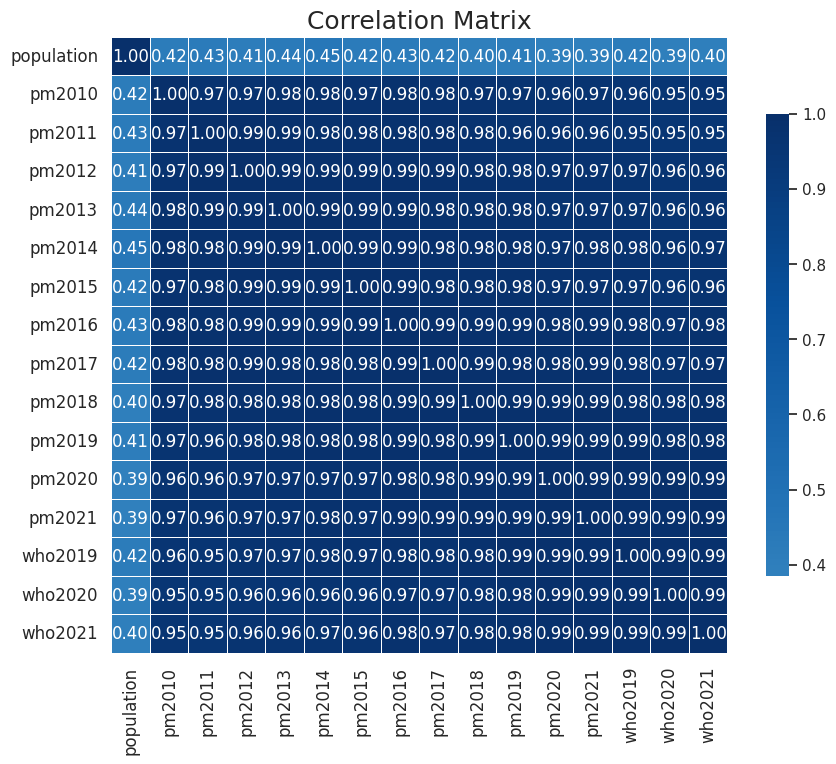

In [22]:
sns.set(style='white')
plt.figure(figsize=(10, 8))
cmap = sns.color_palette("Blues", as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .75}, fmt=".2f")

plt.title('Correlation Matrix', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12) ## Create Correlation Matrix Graph

plt.show()

Through the correlation matrix we can see that all variables are closely correlated with each other except for the variable ‘population’

**4. Clustering**

In [23]:
pollution.describe()

,population,pm2010,pm2011,pm2012,pm2013,pm2014,pm2015,pm2016,pm2017,pm2018,pm2019,pm2020,pm2021,who2019,who2020,who2021
count,2.450000e+02,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000
mean,3.159474e+07,13.440082,13.942980,13.472857,13.106204,12.626612,12.962898,12.489429,12.501878,12.318490,12.301714,12.043306,12.295429,0.774816,0.756816,0.777837
std,1.293535e+08,10.038642,10.732385,10.385283,10.339697,10.005648,10.073385,9.987802,9.616113,9.836786,9.756335,10.125333,10.028642,0.899487,0.932081,0.923787
min,1.400000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.626750e+05,6.040000,5.190000,5.080000,4.970000,5.000000,5.010000,4.810000,4.680000,5.240000,4.860000,4.220000,4.840000,0.000000,0.000000,0.000000
50%,4.957068e+06,11.930000,12.620000,12.270000,11.790000,10.950000,11.570000,11.050000,11.030000,10.960000,10.480000,10.640000,10.820000,0.540000,0.550000,0.570000
75%,2.011902e+07,18.290000,18.560000,18.550000,17.800000,16.940000,17.820000,17.010000,17.370000,16.790000,16.590000,16.750000,16.810000,1.140000,1.150000,1.160000
max,1.402508e+09,65.880000,69.930000,70.670000,65.790000,68.810000,65.150000,65.380000,63.060000,75.780000,67.000000,75.590000,73.960000,6.080000,6.920000,6.760000


I decided to carry out clustering models only with the population variables, PM2021 and who2021, moreover I preferred to use not all observations but only those corresponding to the first decile and the last decile of the dataset

In [24]:
clu = pollution[['name', 'population', 'pm2021', 'who2021']]
clu

,name,population,pm2021,who2021
0,Afghanistan,37461801.0,16.90,1.17
1,Akrotiri and Dhekelia,24378.0,11.15,0.60
2,Albania,3082234.0,13.53,0.84
3,Algeria,43480294.0,6.15,0.11
4,American Samoa,43160.0,1.02,0.00
...,...,...,...,...
247,Western Sahara,646462.0,4.84,0.00
248,Yemen,30314666.0,14.75,0.96
249,Zambia,19089070.0,18.50,1.32
250,Zimbabwe,14804978.0,14.36,0.92


In [25]:
## Calculate the value of the 10th percentile

percentile_10 = clu['pm2021'].quantile(0.10)
percentile_90 = clu['pm2021'].quantile(0.90)

primo_perc = clu[clu['pm2021'] <= percentile_10]
ultimo_perc = clu[clu['pm2021'] >= percentile_90]
print(ultimo_perc)
print(primo_perc)

                                 name    population  pm2021  who2021
17                         Bangladesh  1.648048e+08   73.96     6.76
24                             Bhutan  8.581870e+05   30.59     2.51
25                            Bolivia  1.175907e+07   25.19     1.98
36                            Burundi  1.224228e+07   31.91     2.64
39                           Cameroon  2.856874e+07   30.98     2.55
42           Central African Republic  5.395752e+06   25.57     2.02
45                              China  1.402508e+09   30.20     2.47
59   Democratic Republic of the Congo  1.049949e+08   34.64     2.90
66                        El Salvador  6.485597e+06   25.84     2.04
67                  Equatorial Guinea  8.390500e+05   29.06     2.36
90                          Guatemala  1.740290e+07   29.05     2.36
97                           Honduras  9.310136e+06   25.14     1.97
100                             India  1.338261e+09   58.70     5.26
103                              I

In [26]:
perc_uniti = pd.concat([primo_perc, ultimo_perc])
perc_uniti

,name,population,pm2021,who2021
4,American Samoa,4.316000e+04,1.02,0.00
7,Anguilla,1.666400e+04,2.21,0.00
32,British Virgin Islands,3.304500e+04,2.09,0.00
46,Christmas Island,1.702000e+03,2.18,0.00
48,Cocos Islands,4.930000e+02,1.81,0.00
51,Cook Islands,6.273000e+03,0.96,0.00
71,Falkland Islands,2.884000e+03,2.00,0.00
77,French Polynesia,2.373150e+05,1.40,0.00
86,Greenland,3.128600e+04,1.25,0.00
89,Guam,1.649670e+05,1.33,0.00


In [27]:
## Removing the ‘name’ column and normalising data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(perc_uniti.drop(columns=['name']))

*Hierarchical Clustering*

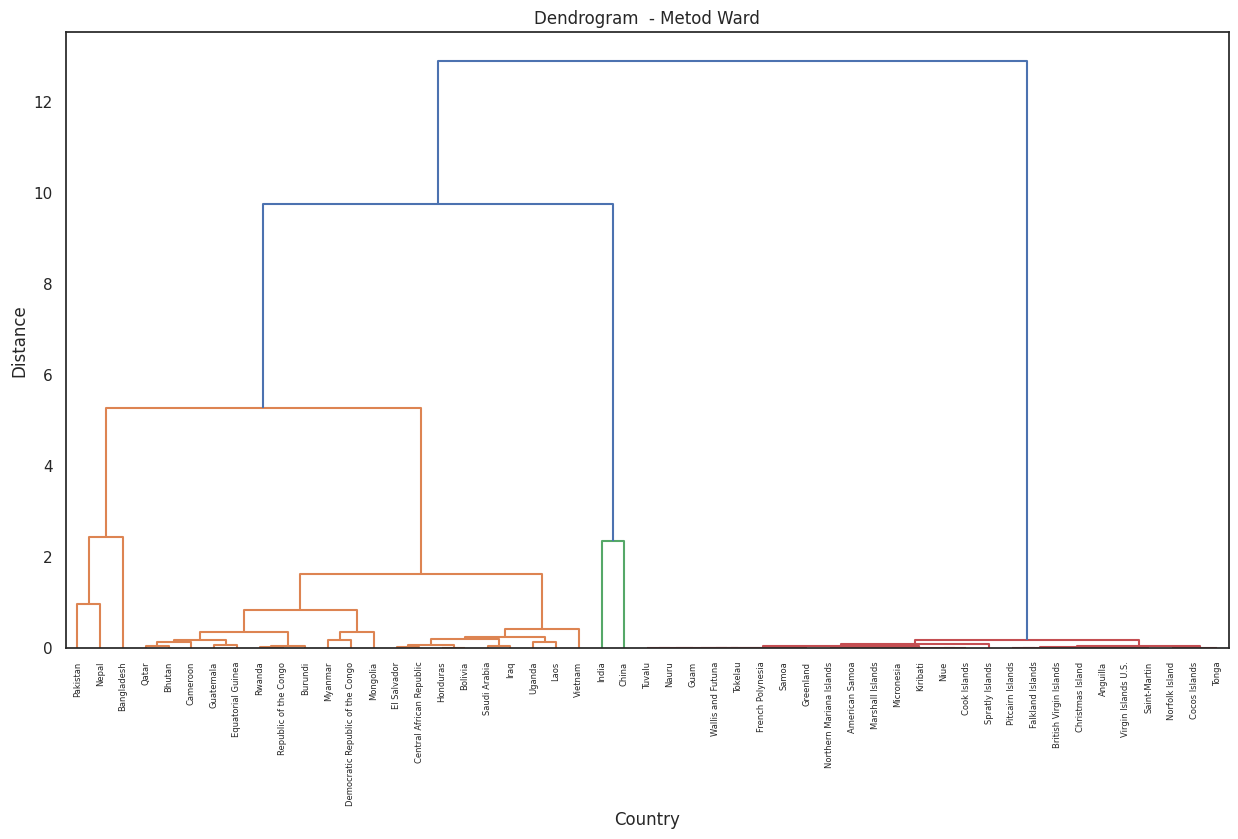

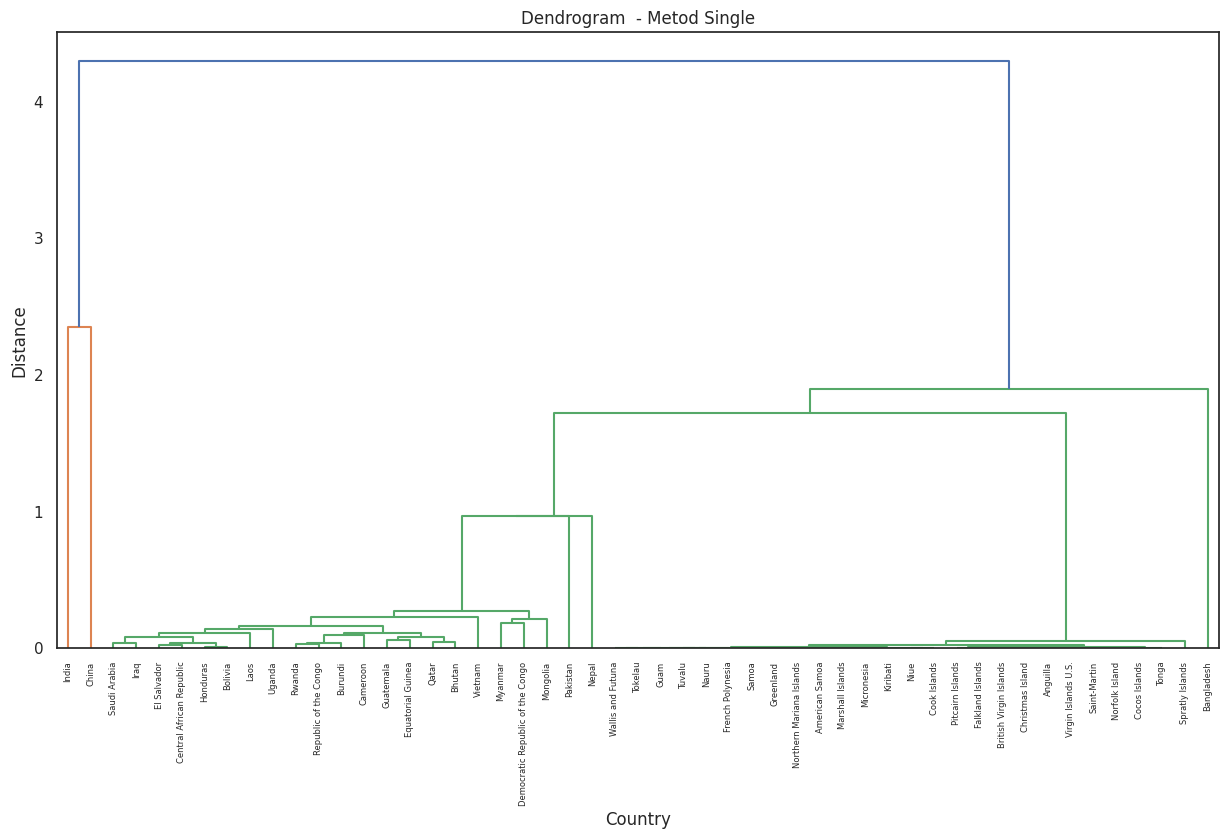

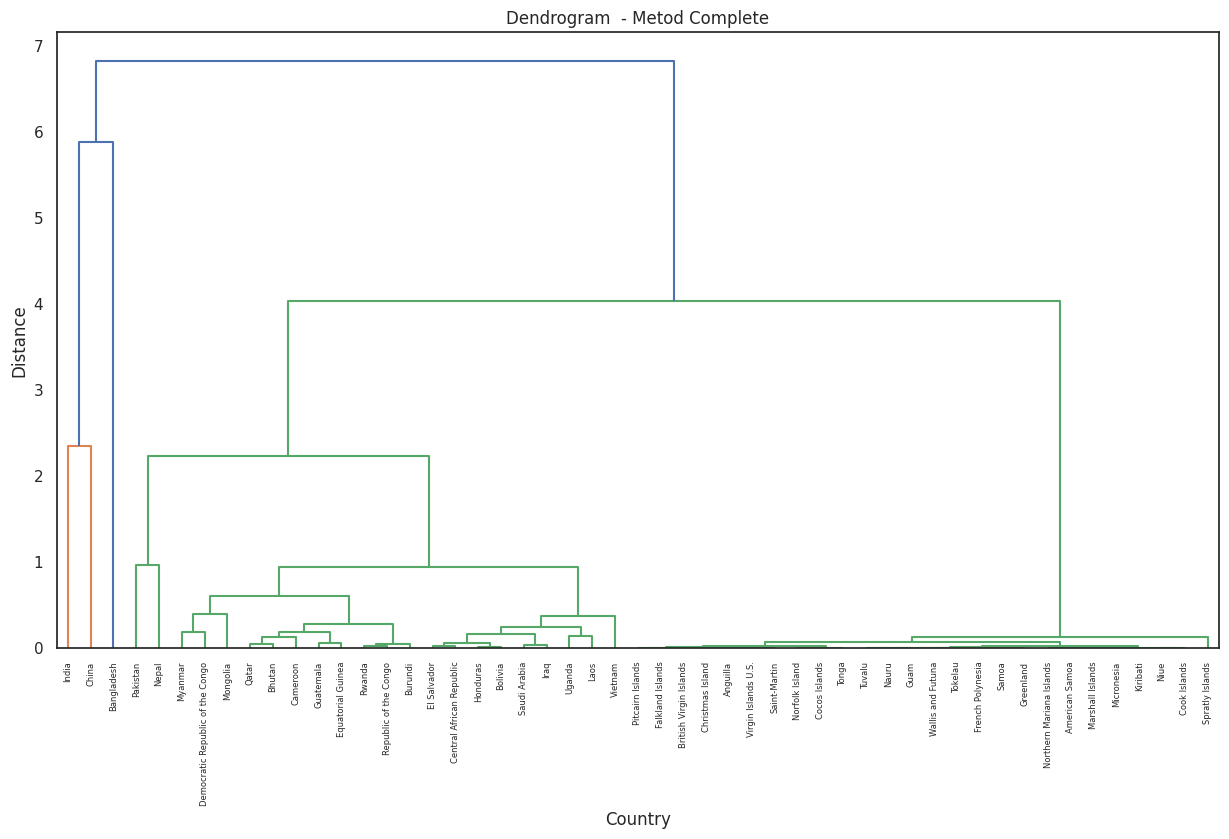

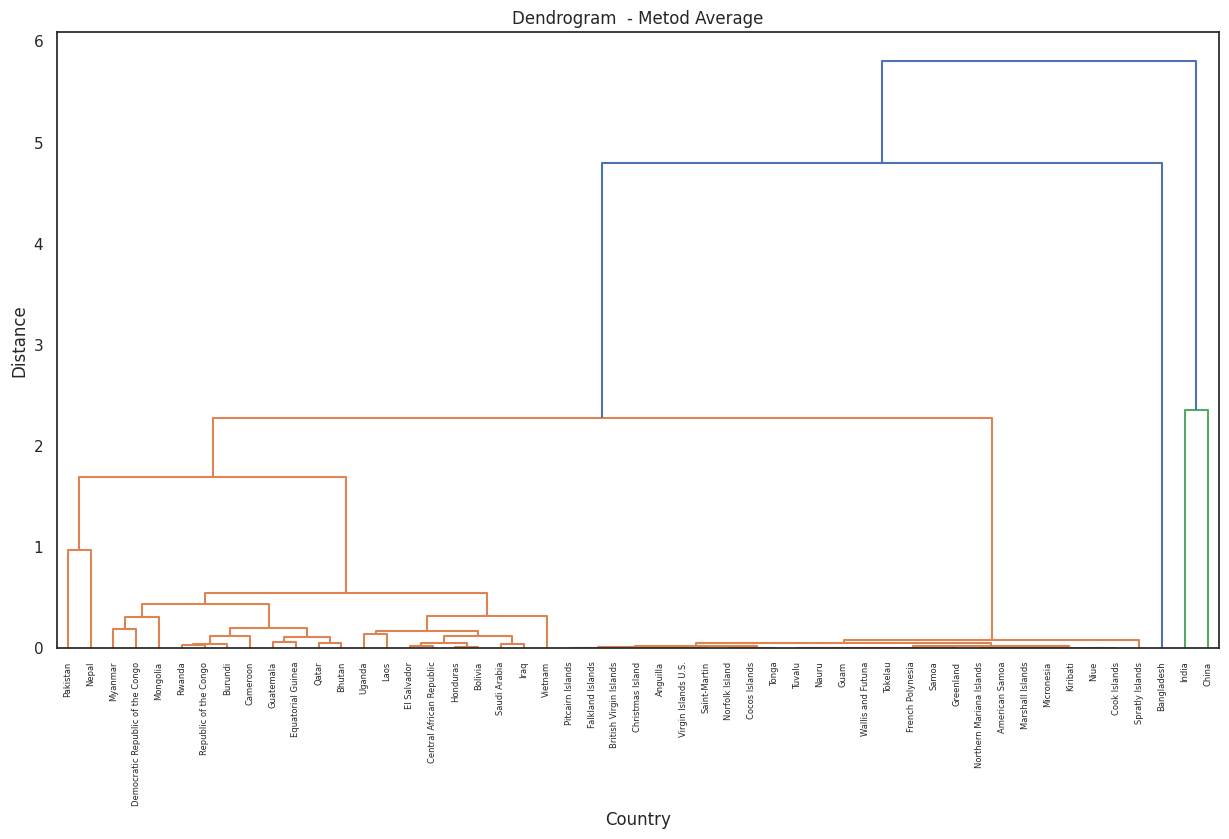

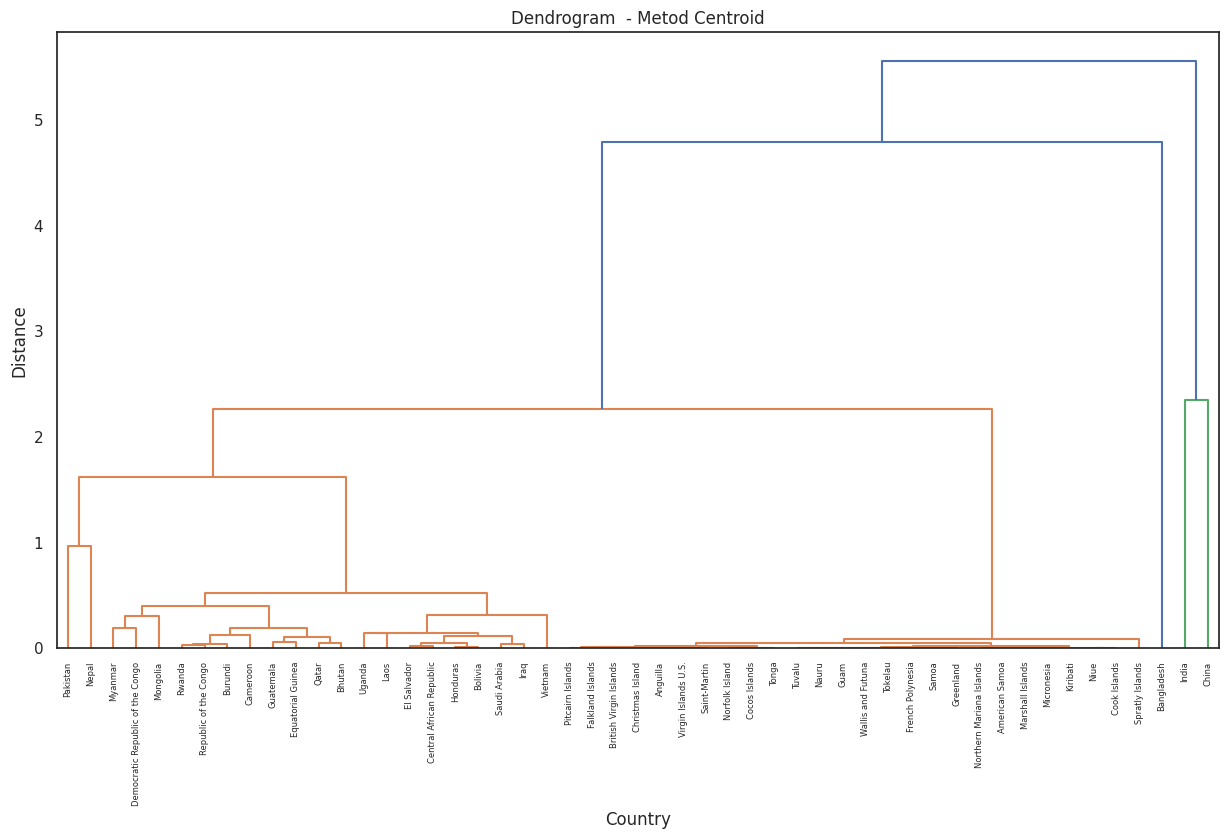

In [28]:
linkage_methods = ['ward', 'single', 'complete', 'average', 'centroid'] ## List of linkage methods to be tested

for method in linkage_methods:
    linked = linkage(scaled_features, method=method)

    plt.figure(figsize=(15, 8))
    dendrogram(linked,
               orientation='top',
               labels=perc_uniti['name'].values,
               distance_sort='descending',
               show_leaf_counts=True)
    plt.title(f'Dendrogram  - Metod {method.capitalize()}')   ## Creation of the dendrogram
    plt.xlabel('Country')
    plt.ylabel('Distance')
    plt.show()

To determine the best linkage method for clustering, I used Silhouette Index.

In [29]:
def calculate_silhouette(scaled_features, linkage_method):
    linked = linkage(scaled_features, method=linkage_method) ## Function for calculating the silhouette index

    max_d = 3  ## example of distance cut-off
    cluster_labels = fcluster(linked, max_d, criterion='distance')

    silhouette_avg = silhouette_score(scaled_features, cluster_labels) ## Calculating the silhouette index
    return silhouette_avg

linkage_methods = ['ward', 'single', 'complete', 'average', 'centroid']

for method in linkage_methods:
    silhouette_avg = calculate_silhouette(scaled_features, method)
    print(f"Metod {method.capitalize()} - Silhouette Index: {silhouette_avg:.4f}")

Metod Ward - Silhouette Index: 0.8450
Metod Single - Silhouette Index: 0.7398
Metod Complete - Silhouette Index: 0.8257
Metod Average - Silhouette Index: 0.6684
Metod Centroid - Silhouette Index: 0.6684


Silhouette index results indicate that for all methods used, the points are well distinguished from points in other clusters and are well clustered within their own cluster, which suggests that the clustering is good.
However, the method that stands out with the highest silhouette index (0.8450) is the Ward method. Visually, all dendograms seem to have a good division between clusters

*KMeans Clustering*

In [30]:
features = ['population', 'pm2021', 'who2021'] ## Selecting features for clustering

scaler = StandardScaler()
df_scaled = scaler.fit_transform(perc_uniti[features])## Standardizing the features

Elbow method to find the optimal number of clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

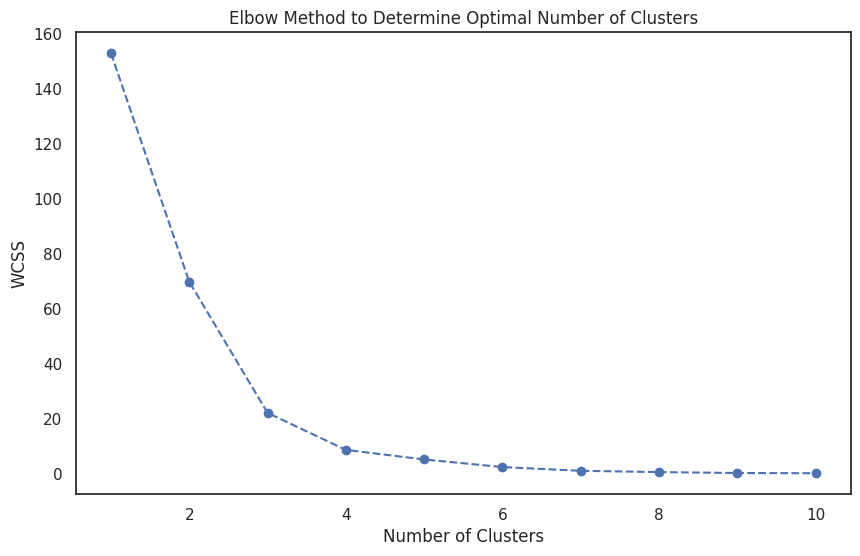

In [31]:
wcss = []  # Within-cluster sum of squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method to Determine Optimal Number of Clusters') ## Plotting the elbow curve
plt.show()


Through the Elbow Method we can determine that the ideal number of clusters in the KMeans method we are going to use is 3

In [32]:
kmeans = KMeans(n_clusters=3, random_state=42) ## Applying K-means with the chosen number of clusters
clusters = kmeans.fit_predict(df_scaled)

perc_uniti['Cluster'] = clusters ## Adding the cluster labels to the original DataFrame

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



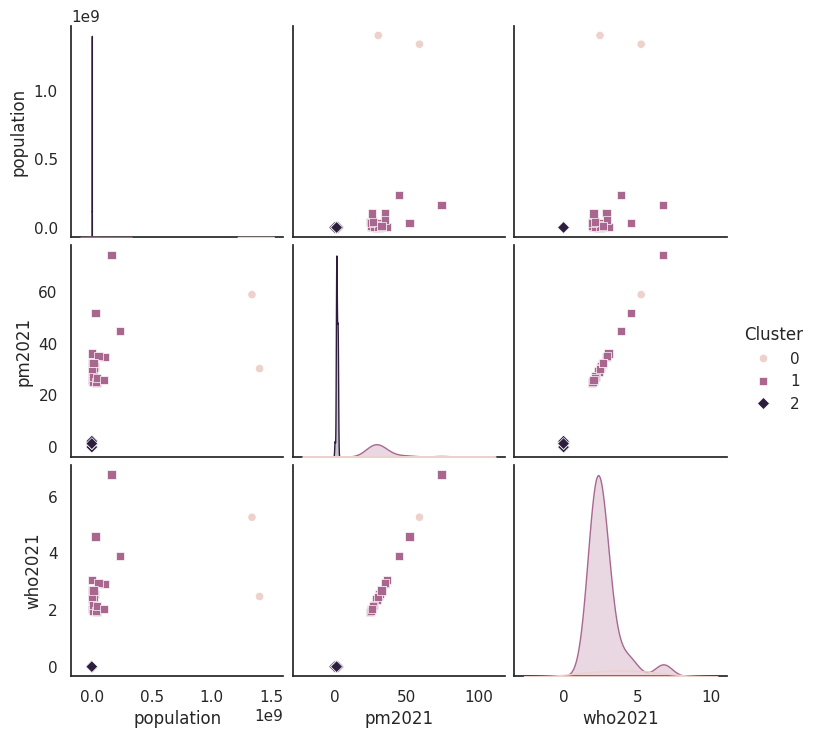

In [33]:
sns.pairplot(perc_uniti, hue='Cluster', diag_kind='kde', markers=['o', 's', 'D'])
plt.show()


**Cluster:**

*Cluster 0*, countries in this cluster tend to have very large populations and variable life expectancy. This cluster is rather heterogeneous and includes countries with variable PM2.5 levels;
*Cluster 1*, the countries in this cluster have relatively small populations, low PM2.5 levels and high life expectancy. This cluster seems to represent cities with good air quality and favourable living conditions;
*Cluster 2*, this cluster includes countries with a very small population, low PM2.5 levels and very high life expectancy. This cluster probably represents the cleanest and least populated countries with the best living conditions.

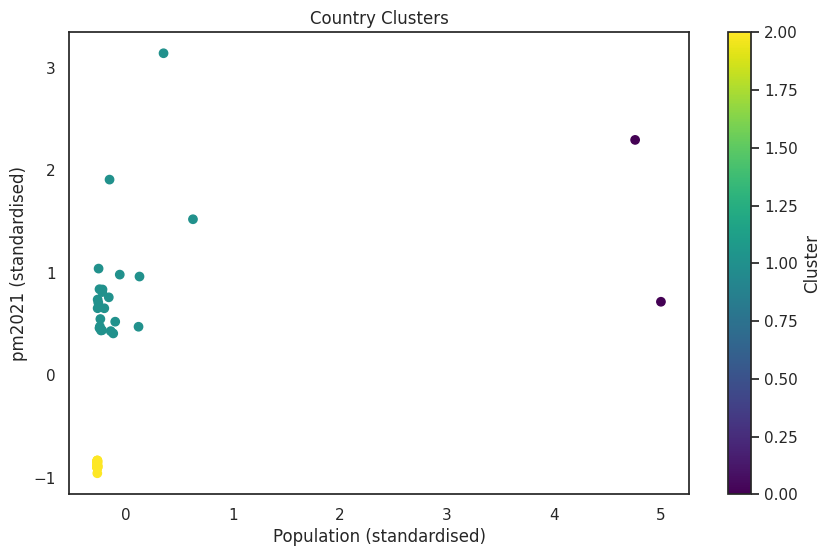

In [34]:
plt.figure(figsize=(10, 6)) ## Visualising clusters with a scatter plot of the first two standardised characteristics (poulation and PM2021)

plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=perc_uniti['Cluster'], cmap='viridis', marker='o')

plt.xlabel('Population (standardised)')
plt.ylabel('pm2021 (standardised)')
plt.title('Country Clusters')
plt.colorbar(label='Cluster')
plt.show()


With the next lines of code I decided to display a choropletic map with the results of the KMeans model

In [35]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) ## Load the world shapefile

<ipython-input-35-6872a2614586>:1: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



In [36]:
world = world.merge(perc_uniti, how='left', on='name') ## Merging clustering data with the GeoDataFrame
clustered_world = world.dropna(subset=['Cluster'])

<ipython-input-37-54f803af56d0>:10: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




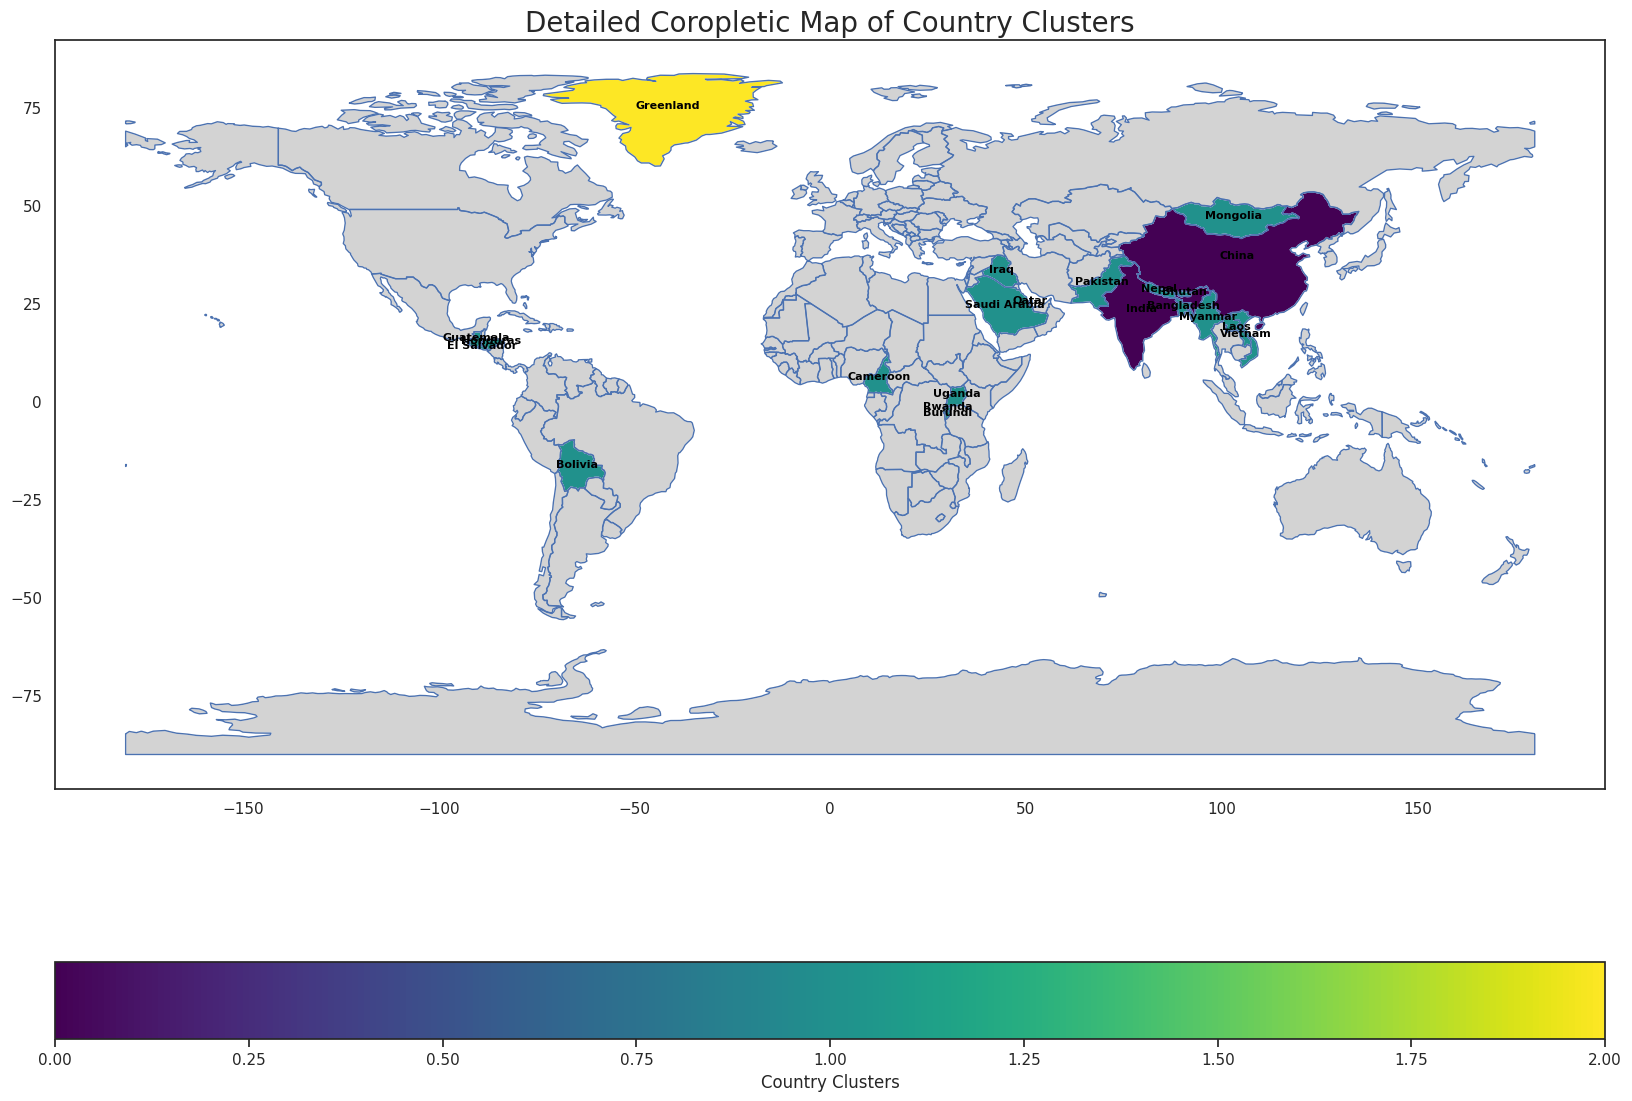

In [37]:
##Creating the detailed coropletic map
fig, ax = plt.subplots(1, 1, figsize=(20, 15))

world.boundary.plot(ax=ax, linewidth=1)
world.plot(column='Cluster', ax=ax, legend=True,
           legend_kwds={'label': "Country Clusters", 'orientation': "horizontal"},
           cmap='viridis', missing_kwds={"color": "lightgrey", "label": "No Data"})

# Aggiungere annotazioni solo per i paesi clusterizzati
for x, y, label in zip(clustered_world.geometry.centroid.x, clustered_world.geometry.centroid.y, clustered_world['name']):
    ax.text(x, y, label, fontsize=8, ha='center', color='black', weight='bold')

# Titolo e visualizzazione
plt.title('Detailed Coropletic Map of Country Clusters', fontsize=20)
plt.show()


*Linear Regression*


Finally, I decided to implement a linear regression model to forecast the next five years for Bangladesh (country with the highest PM2.5 index)

In [38]:
# Seleziona la riga corrispondente
country_max = pd.read_csv("aqli_global.csv")
country_max = country_max.filter(regex='^(name|pm)')
country_max.columns = ['year', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
country_max = country_max.set_index('year')
country_max = country_max.transpose()
country_max = country_max[['Bangladesh']]
country_max.columns = [ 'PM(Bangladesh)']
# Imposta l'indice del DataFrame come una sequenza di anni
country_max.index = pd.date_range(start='1998-01-01', periods=len(country_max), freq='Y')


# Resetta l'indice per trasformarlo in una colonna
country_max = country_max.reset_index()

# Rinomina la colonna dell'indice come 'Anno'
country_max = country_max.rename(columns={'index': 'year'})
country_max = country_max.set_index('year')

if country_max.index.name == 'year':
    country_max.reset_index(inplace=True)

print(country_max)

         year  PM(Bangladesh)
0  1998-12-31           45.39
1  1999-12-31           45.68
2  2000-12-31           51.32
3  2001-12-31           53.66
4  2002-12-31           53.42
5  2003-12-31           54.98
6  2004-12-31           54.44
7  2005-12-31           59.48
8  2006-12-31           64.13
9  2007-12-31           62.01
10 2008-12-31           65.24
11 2009-12-31           70.40
12 2010-12-31           65.88
13 2011-12-31           69.93
14 2012-12-31           70.67
15 2013-12-31           65.79
16 2014-12-31           68.81
17 2015-12-31           65.15
18 2016-12-31           65.38
19 2017-12-31           63.06
20 2018-12-31           75.78
21 2019-12-31           67.00
22 2020-12-31           75.59
23 2021-12-31           73.96


With the previous lines of code I made sure that we have only one variable in which we are interested ‘PM(Bangladesh)’ and as observations the years

                            OLS Regression Results                            
Dep. Variable:         PM(Bangladesh)   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     75.59
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           1.44e-08
Time:                        10:33:05   Log-Likelihood:                -67.729
No. Observations:                  24   AIC:                             139.5
Df Residuals:                      22   BIC:                             141.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2126.0106    251.762     -8.445      0.0

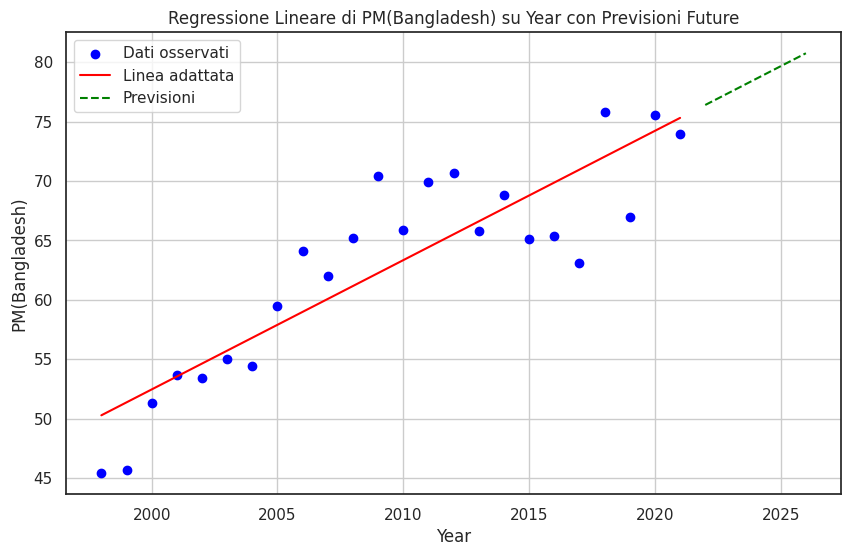

   year  Predicted PM(Bangladesh)
0  2022                 76.413297
1  2023                 77.502528
2  2024                 78.591758
3  2025                 79.680988
4  2026                 80.770219


In [39]:
country_max['year'] = pd.to_datetime(country_max['year']) ## Converting the `year` variable to datetime format

country_max['year_num'] = country_max['year'].dt.year ## Extract the year and use it as an independent variable

X = country_max['year_num']
Y = country_max['PM(Bangladesh)'] ## Dividing the data into dependent (Y) and independent (X) variables

X = sm.add_constant(X) ## Adding a constant to the independent variable

model = sm.OLS(Y, X).fit() ## Creating and fitting the linear regression model

print(model.summary())

future_years = np.arange(2022, 2027)
future_years_with_constant = sm.add_constant(future_years) ## Generate data for forecast (next 5 years)

predictions = model.predict(future_years_with_constant)

plt.figure(figsize=(10, 6))
plt.scatter(country_max['year_num'], Y, color='blue', label='Dati osservati')
plt.plot(country_max['year_num'], model.fittedvalues, color='red', label='Linea adattata')
plt.plot(future_years, predictions, color='green', linestyle='dashed', label='Previsioni')
plt.xlabel('Year')
plt.ylabel('PM(Bangladesh)')
plt.title('Regressione Lineare di PM(Bangladesh) su Year con Previsioni Future')
plt.legend()
plt.grid(True)
plt.show() ## Displaying Results

future_country_max = pd.DataFrame({'year': future_years, 'Predicted PM(Bangladesh)': predictions})
print(future_country_max)

**Model Evaluation**

*- R-squared(0.775)*: indicates that the model explains 77.5% of the variability in the data suggesting that the model has good explanatory power;

*- Adj. R-squared(0.764)*: the adjusted R-squared indicates a good fit of the model;

*- F-statistic(75.59)*: this F-statistic and its associated p-value ‘Prob (F-statistic): 1.44e-08’ indicate that the model is statistically significant;

*- year_num (1.0892*): indicates that for each one-year increase, the value of PM(Bangladesh) increases by about 1.0892. This coefficient is highly significant with a p-value of 0.000;

*- Skew(-0.034)*: Indicates that the distribution of residuals is slightly skewed to the left, but very close to zero, thus practically symmetrical;

*- Kurtosis(2.256)*: indicates that the distribution of residuals has a shape similar to the normal distribution (ideal value is 3).

**Conclusion**

The linear regression model shows a good fit to the data with a high R-squared (0.775) and a significant coefficient for year (year_num),
F-statistics and p-values indicate that the model is highly significant.
The residuals suggest that there are no significant problems of non-normality or autocorrelation.
The model can be considered robust for the prediction of future PM(Bangladesh) values.